Loading Library

In [1]:
import gc
import os,h5py
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
from torch import nn,optim
import matplotlib.pyplot as plt

import os, glob
from scipy.ndimage import map_coordinates
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
DATA_ROOT_FOLDER = '/kaggle/input/textiledefectdetection'

In [3]:
class TextureDataset(Dataset):
    filenames = {64: dict(train=('train64.csv', 'train64.h5'), test=('test64.csv', 'test64.h5')),
                 32: dict(train=('train32.csv', 'train32.h5'), test=('test32.csv','test32.h5'))}
    indication_classes = ['index', 'angle', 'indication_type', 'indication_value', 'split']
    def __init__(self,root_folder, train=True, patch_size=64, classification=True, task='defect',keep_angles=True,keep_defects=False, transformation=None, test_sub_sample=200):
        if os.path.exists(root_folder):
            self.root_folder = root_folder
        else:
            raise IOError('The path of the directory is incorrect or doesn\'t exist')
        
        self.patch_size = patch_size if patch_size in self.filenames.keys() else 32
        self.infos, self.data = self.load_data(train)
        if train:
            if classification:
                #print('Classification Task:', end=' ')
                if task=='defect' and not keep_angles:    
                    self.infos = self.infos.loc[self.infos['angle']==0]
                    #print('Drop all angles others than 0')
                elif task=='angle' and not keep_defects:
                    self.infos = self.infos.loc[self.infos['indication_type']=='good']
                    print('Drop all defect (all other than good)')
                else:
                    print('Keepíng all the data')
                    pass
            else:
                print('By default only keep healthy')
                self.infos = self.infos.loc[(self.infos['indication_type']=='good') & (self.infos['angle']==0)]
            self.data = self.data[self.infos.index]
        self.transformation = transforms.Compose([transforms.ToTensor()]) if transformation is None  else  transformation
        
        
        if not train and test_sub_sample:
            X = []
            newinfo = pd.DataFrame()
            for (a,t), df in self.infos.groupby(['angle','indication_type']):
                index = df.index
                subi = np.random.choice(index, test_sub_sample, replace=False)
                X.append(self.data[subi])
                newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)
            self.infos = newinfo
            self.data = np.concatenate(X)
    
    def __len__(self):
        return self.infos.shape[0]
        
    def __getitem__(self,index):
        info = self.infos.iloc[index]
        angle, indication_value = int(info['angle'])//20, int(info['indication_value'])
        img = self.data[index]
        
        return self.transformation(img),angle, indication_value
            
    
    def load_data(self,train):
        files = self.filenames[self.patch_size]
        infos_filename, data_filename = files['train'] if train else files['test']
        
        infos = pd.read_csv(os.path.join(self.root_folder,infos_filename))
        data = None
        with h5py.File(os.path.join(self.root_folder,data_filename),mode='r') as h5file:
            data = h5file['images'][:]
        return infos, data        
    
    @staticmethod
    def get_angles_classes():
        return np.arange(8)* 20
    @staticmethod
    def get_indication_classes():
        return ['good', 'color', 'cut',  'hole', 'thread', 'metal_contamination']
    @staticmethod
    def compute_normalization_parameters(root):
        print('#### Compute Mean and Std of image for image scaling')
        dataset = TextureDataset(root_folder=root, classification=True,task='angle',keep_defects=False)
        loader = DataLoader(dataset,batch_size=15, num_workers=4, shuffle=True)
        mean = 0.
        std = 0.
        for images, _,_ in loader:
            batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= len(loader.dataset)
        std /= len(loader.dataset)
        print(f""" Normalize the data as following:
        transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize({mean}, {std} )])
        this function return the object Normalize the new mean and std: transforms.Normalize({mean}, {std} )
        """)
        return transforms.Normalize(mean, std )

In [4]:
from torch import nn
import torch


for i in range(torch.cuda.device_count()):
    print("Found device {}:".format(i), torch.cuda.get_device_name(i))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

class Cudafy(object):
    
    def __init__(self, device=None):
        if torch.cuda.is_available() and device:
            self.device = device
        else:
            self.device = 0
    
    def name(self):
        if torch.cuda.is_available():
            return torch.cuda.get_device_name(self.device)
        return 'Cuda is not available.'
    
    def put(self, x):
        """Put x on the default cuda device."""
        if torch.cuda.is_available():
            return x.to(device=self.device)
        return x

    def __call__(self, x):
        return self.put(x)
    
    def get(self,x):
        """Get from cpu."""
        if x.is_cuda:
            return x.to(device='cpu')
        return x
    
def cpu(x):
    if x.is_cuda:
        return x.to(device='cpu')
    return x

Found device 0: Tesla P100-PCIE-16GB
Current cuda device is Tesla P100-PCIE-16GB


AutoEncoder Model

In [5]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args.n_channel
        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.main = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        self.fc = nn.Linear(self.dim_h * (2 ** 5), self.n_z)

    def forward(self, x):
        x = self.main(x)
             
        
        x=x.view(-1,self.dim_h * (2 ** 5))
        #x = x.squeeze()
        #print('x before fc',x.shape)
        x = self.fc(x)
        return x
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        self.n_channel = args.n_channel
        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.proj = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 2 * 2),
            nn.ReLU()
        )
        self.main = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(self.dim_h * 8, self.dim_h * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(self.dim_h * 2, self.dim_h , 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(self.dim_h, self.n_channel , 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.n_channel),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.proj(x)
        x = x.view(-1, self.dim_h * 8, 2, 2)
        x = self.main(x)
        return x
class AE(nn.Module):

    def __init__(self,args):
        super(AE, self).__init__()
        self.encoder = Encoder(args)
        self.decoder = Decoder(args)
    
    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)

Custom AE

In [6]:
class cEncoder(nn.Module):
    def __init__(self, args):
        super(cEncoder, self).__init__()

        self.n_channel = args.n_channel
        self.dim_h = args.dim_h
        self.n_z = args.n_z
        self.edoor=args.edoor
        self.eBias=args.dBias


        self.main = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=self.eBias),
            self.edoor,
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=self.eBias),
            nn.BatchNorm2d(self.dim_h * 2),
            self.edoor,
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=self.eBias),
            nn.BatchNorm2d(self.dim_h * 4),
            self.edoor,
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=self.eBias),
            nn.BatchNorm2d(self.dim_h * 8),
            self.edoor,
        )
        self.fc = nn.Linear(self.dim_h * (2 ** 5), self.n_z)

    def forward(self, x):
        x = self.main(x)
             
        
        x=x.view(-1,self.dim_h * (2 ** 5))
        #x = x.squeeze()
        #print('x before fc',x.shape)
        x = self.fc(x)
        return x
class cDecoder(nn.Module):
    def __init__(self, args):
        super(cDecoder, self).__init__()
        self.n_channel = args.n_channel
        self.dim_h = args.dim_h
        self.n_z = args.n_z
        self.finalLayer=args.fl
        self.ddoor=args.ddoor
        self.dBias=args.eBias

        self.proj = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 2 * 2),
            nn.ReLU()
        )
        self.main = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False),
            nn.Conv2d(self.dim_h * 8, self.dim_h * 4, 3, 1, 1, bias=self.dBias),
            nn.BatchNorm2d(self.dim_h * 4),
            self.ddoor,
            nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 2, 3, 1, 1, bias=self.dBias),
            nn.BatchNorm2d(self.dim_h * 2),
            self.ddoor,
            nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False),
            nn.Conv2d(self.dim_h * 2, self.dim_h , 3, 1, 1, bias=self.dBias),
            nn.BatchNorm2d(self.dim_h),
            self.ddoor,
            nn.Upsample(scale_factor=2, mode='bilinear',align_corners=False),
            nn.Conv2d(self.dim_h, self.n_channel , 3, 1, 1, bias=self.dBias),
            nn.BatchNorm2d(self.n_channel),
            self.finalLayer,
        )
    def forward(self, x):
        x = self.proj(x)
        x = x.view(-1, self.dim_h * 8, 2, 2)
        x = self.main(x)
        return x
class cAE(nn.Module):

    def __init__(self,args):
        super(cAE, self).__init__()
        self.encoder = cEncoder(args)
        self.decoder = cDecoder(args)
    
    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)

Parameters

In [7]:
def make_model(dim_h,n_z,n_channel):
    class Arg():
        def __init__(self):
            pass
            
    args = Arg()
    args.dim_h = dim_h
    args.n_z = n_z
    args.n_channel = n_channel    
    model = AE(args=args)

    return model

In [8]:

def make_custom_model(dim_h,n_z,n_channel):
    class Arg():
        def __init__(self):
            pass
            
    args = Arg()
    args.dim_h = dim_h
    args.n_z = n_z
    args.n_channel = n_channel
    args.eBias = True
    args.dBias = False
    args.edoor = nn.ReLU(True) #Encoder door
    args.ddoor = nn.ReLU(True) #Decoder door
    args.fl    = nn.Sigmoid()
    
    model = cAE(args=args)

    return model

run train on the dataset

In [9]:
from torchvision import transforms,utils

def getdataloader(root, patch_size=32, task='defect',batch_size=32,keep_angles=False,test_sub_sample=False,num_workers=5, *args,**kwargs):
    
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352]), transforms.RandomErasing(0.3, value=0)])
    
    dataset = TextureDataset(root,train=True,patch_size=patch_size, classification=True, task=task, transformation=transformation,keep_angles=keep_angles)
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=True)
    
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    
    dataset = TextureDataset(root,train=False,patch_size=patch_size, classification=True, task=task, transformation=transformation,test_sub_sample=test_sub_sample)
    val_loader = DataLoader(dataset=dataset,batch_size=int(batch_size*2),shuffle=False,num_workers=num_workers)
    
    return train_loader, val_loader

In [10]:
def run_train(model, batch_size, patch_shape, epochs, lr, test_sub_sample, optim, crit, display):

    
    gpu = Cudafy(device=0)
    model = gpu(model)
    
    funcdict = {
        'Adam': torch.optim.Adam,
        'SGD': torch.optim.SGD,
        'Adadelta': torch.optim.Adadelta,
        'RMSprop': torch.optim.RMSprop,
    }

    optim = funcdict[optim](model.parameters(), lr = lr)
    
    #optim = optim(model.parameters(), lr = lr)
    criterion = crit
    
    
     #Load Data
    
    train_loader,valid_loader=getdataloader(root='/kaggle/input/textiledefectdetection', patch_size=patch_shape, batch_size=batch_size, task='defect',test_sub_sample=test_sub_sample, nclasses = len(TextureDataset.get_indication_classes()))

    metric = dict(l2_train=[],l2_valid=[])
    if(display):
        print(f'total iterations: {len(train_loader)}')
    for epoch in range(epochs):
        if(display):
            print(f'Epoch: {epoch}')
        b = []
        model.train()
        for it,data  in enumerate(train_loader):
            img, _, _ = data
            img = gpu(img)
            output = model(img)
            loss = criterion(output, img)
            optim.zero_grad() # Backward & update weights
            loss.backward()
            b.append( cpu(loss).item())
            if display and (it%50==0 or it==len(train_loader)):
                print(f'it: {it}, loss: {b[-1]}')
            optim.step()
        metric['l2_train'].append(np.mean(b))
        model.eval()
        b = []
        with torch.no_grad():
            if(display):
                print('computing loss in validation set')
            for itval, data  in enumerate(valid_loader):
                if display and (itval%50==0 or itval==len(valid_loader)):
                    print(f'it:{itval}/{len(valid_loader)}')
                img, _, _ = data
                img = gpu(img)
                output = model(img)
                loss = criterion(output, img)
                b.append( cpu(loss).numpy()) 
        metric['l2_valid'].append( np.mean(b))  

    ret=loss
    if(display):
        plt.figure()
        metric = pd.DataFrame(metric)
        metric['epochs'] = np.arange(epochs)
        metric = pd.melt(metric,id_vars='epochs', value_vars=['l2_train','l2_valid'])
        sns.lineplot(x='epochs', y='value',hue='variable',data=metric)  
    # test on a dataset
    model.eval()
    print('',end='\r')

    with torch.no_grad():

        for data in valid_loader:
            img, _, _ = data
            img = gpu(img)
            output = model(img)
            loss = criterion(output, img)
                                                    
            if(display):
                fig, axes = plt.subplots(1, 2, figsize=(20,10))
                axes = axes.ravel()
                for ax,i in zip(axes,[img, output]):
                    grid_img = utils.make_grid(cpu(i),nrow=8).permute(1, 2, 0)
                    ax.imshow(grid_img)
                plt.axis('off')
            break#only show one, the whole validset is too big to visualize
            
    return ret

In [11]:
#@title Parameters

p_batch_size = 32 #@param {type:"slider", min:0, max:128, step:16}
p_patch_size = 32
p_test_sub_sample=100
p_epochs =  5#@param {type:"integer"}
p_lr = 1e-3 #@param {type:"number"}
p_dim_h = 128 #@param {type:"integer"}
p_n_z = 32 #@param {type:"integer"}
p_n_channel = 1 #@param {type:"integer"}
crit = nn.MSELoss()     #I want to test the nn.NNL() in this case3.0
optim='Adam'


class Arg():
    def __init__(self):
        pass

args = Arg()
args.dim_h = p_dim_h
args.n_z = p_n_z
args.n_channel = p_n_channel
args.eBias = True
args.dBias = False
args.edoor = nn.ReLU(True) #Encoder door
args.ddoor = nn.ReLU(True) #Decoder door
args.fl    = nn.Sigmoid()

model = cAE(args=args)

#run_train(model=model, batch_size = p_batch_size, patch_shape=p_patch_size, epochs = p_epochs, lr = p_lr,test_sub_sample=p_test_sub_sample, optim=optim, crit = crit,display=False)

In [12]:
def make_model(p_dim_h, p_n_z, p_n_channel):
    class Arg():
        def __init__(self):
            pass

    args = Arg()
    args.dim_h = p_dim_h
    args.n_z = p_n_z
    args.n_channel = p_n_channel
    args.eBias = True
    args.dBias = False
    args.edoor = nn.ReLU(True) #Encoder door
    args.ddoor = nn.ReLU(True) #Decoder door
    args.fl    = nn.Sigmoid()
    
    model = cAE(args=args)
    
    return model

In [13]:
from statistics import variance 

def ultimateExperiments():
    #@title Parameters

    p_batch_size = [32, 64] #@param {type:"slider", min:0, max:128, step:16}
    p_patch_size = 32
    p_test_sub_sample=100
    p_epochs = 5 #[1, 50, 150, 300] #@param {type:"integer"}
    p_lr = [1e-3, 1e-2, 1e-1] #@param {type:"number"}
    p_dim_h = [64, 128] #@param {type:"integer"}
    p_n_z = [32, 64, 128] #@param {type:"integer"}
    p_n_channel = 1 #@param {type:"integer"}
    crit = [nn.MSELoss(), nn.NLLLoss]  #I want to test the nn.NNL() in this case3.0
    optim=['Adam', 'SGD', 'RMSprop']
    repet=2
    
    count=1
    
    model = make_model(p_dim_h[1], p_n_z[1], p_n_channel)
    #run_train(model=model, batch_size = p_batch_size[0], patch_shape=p_patch_size[0], epochs = p_epochs[0], lr = p_lr[0], test_sub_sample=p_test_sub_sample[0], optim=optim[0], crit = crit[0], display=False)
    #metric=run_train(model=model, batch_size = batch, patch_shape=p_patch_size[0], epochs = epoch, lr = l, test_sub_sample=sample, optim=optim[0], crit = crit[0], display=False)
    min_var=10
    list_s=[]
    run_list=[]
    idx=0
    
    for batch in p_batch_size :
        for opt in optim :
            for l in p_lr :

                var=[]
                run=[count, batch, p_test_sub_sample, p_epochs, l, opt]
                run_list.append(run)
                run_name='Run n°'+str(count)+', batch_size='+str(batch)+', sample=' + str(p_test_sub_sample)+ ', epochs='+str(p_epochs)+', lr='+str(l)+', optim='+opt
                print(run_name)

                list_s.append(run_name)
                

                for i in np.arange(repet):

                    p=run_train(model=model, batch_size = batch, patch_shape=p_patch_size, epochs = p_epochs, lr = l, test_sub_sample=p_test_sub_sample, optim=opt, crit = crit[0], display=False)
                    p=p.detach().cpu().numpy()

                    var.append(p)
                var=list(map(float,var))

                var=variance(var)

                if var<min_var:
                    min_var=var
                    idx=count-1

                print('Loss Variance = '+ str(var))
                
                count=count+1
            
    print('BEST PARAMETERS : '+list_s[idx])

    run_train(model=model, batch_size = run_list[idx][1], patch_shape=p_patch_size, epochs = run_list[idx][3], lr = run_list[idx][4], test_sub_sample=run_list[idx][2], optim=run_list[idx][5], crit = crit[0], display=True)

Run n°1, batch_size=32, sample=100, epochs=5, lr=0.001, optim=Adam
Loss Variance = 0.01127124059481055
Run n°2, batch_size=32, sample=100, epochs=5, lr=0.01, optim=Adam
Loss Variance = 0.00028409773565840624
Run n°3, batch_size=32, sample=100, epochs=5, lr=0.1, optim=Adam
Loss Variance = 0.0001481352521253143
Run n°4, batch_size=32, sample=100, epochs=5, lr=0.001, optim=SGD
Loss Variance = 0.0009311159061713425
Run n°5, batch_size=32, sample=100, epochs=5, lr=0.01, optim=SGD
Loss Variance = 0.0023724421802899798
Run n°6, batch_size=32, sample=100, epochs=5, lr=0.1, optim=SGD
Loss Variance = 0.0009016495596387841
Run n°7, batch_size=32, sample=100, epochs=5, lr=0.001, optim=RMSprop
Loss Variance = 0.00020156909415192104
Run n°8, batch_size=32, sample=100, epochs=5, lr=0.01, optim=RMSprop
Loss Variance = 0.0015684536613491673
Run n°9, batch_size=32, sample=100, epochs=5, lr=0.1, optim=RMSprop
Loss Variance = 0.0053959284434839105
Run n°10, batch_size=64, sample=100, epochs=5, lr=0.001, o

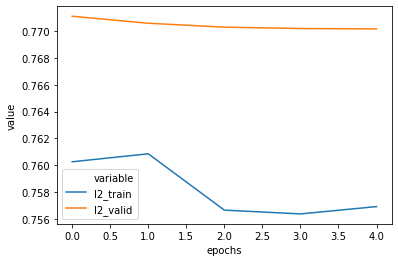

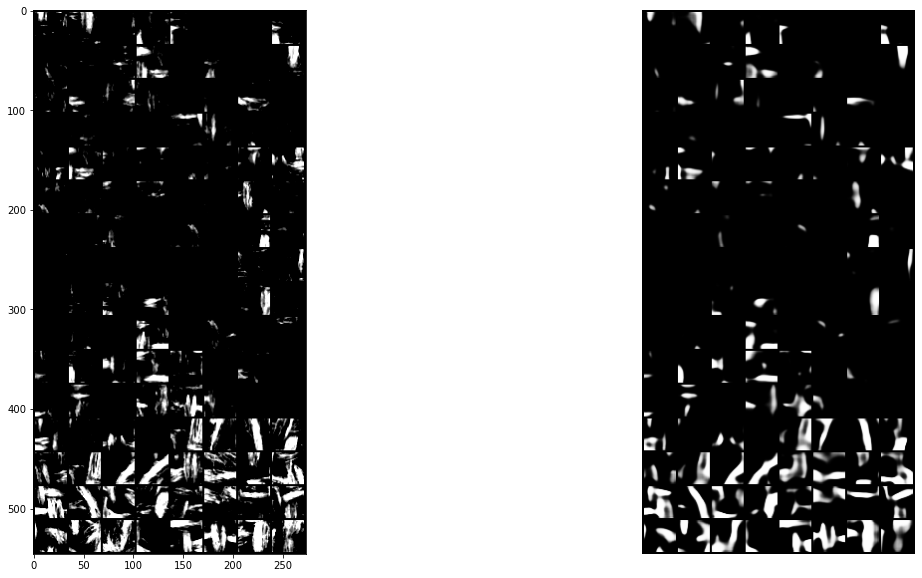

In [14]:
ultimateExperiments()

In [15]:
#run_train(model=model, batch_size = p_batch_size, patch_shape=p_patch_size, epochs = p_epochs, lr = p_lr,dim_h = p_dim_h,n_z = p_n_z,n_channel = p_n_channel,test_sub_sample=p_test_sub_sample, optim=optim, crit = crit,dispay=True)